In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
from tensorflow import keras
tf.__version__

'1.15.0'

In [4]:
import twoModelAnalysis as TWA

In [5]:
# this is the setting for plots for research paper and articles.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
plt.rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})

# Set the font used for MathJax - more on this later
plt.rc('mathtext',**{'default':'regular'})

# Set the style for seaborn 
plt.style.use(['seaborn-white', 'seaborn-paper'])

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize': 'medium',
         'xtick.labelsize': 'small',
         'ytick.labelsize': 'small'
         }

pylab.rcParams.update(**params)

import seaborn as sns
sns.set_context(rc=params)

def stylize_axes(ax, title):
    # removes the top and right lines from the plot rectangle
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.xaxis.set_tick_params(top=False, direction='out', width=1)
    ax.yaxis.set_tick_params(right=False, direction='out', width=1)
    
    # Enforce the size of the title, label and tick labels
    #ax.set_xlabel(ax.get_xlabel(), fontsize='medium')
    #ax.set_ylabel(ax.get_ylabel(), fontsize='medium')
    
    #ax.set_yticklabels(ax.get_yticklabels(), fontsize='medium')
    #ax.set_xticklabels(fontsize='medium')
   
    ax.set_title(title)
    
def save_image(fig, title):
    if title is not None:
        fig.savefig('../Results/images/'+title+".png", dpi=300, bbox_inches='tight', transparent=True)
        fig.savefig('../Results/images/'+title+".pdf", bbox_inches='tight')

def figure_size(fig, size):
    fig.set_size_inches(size)
    fig.tight_layout()

In [6]:
sns.set(font_scale=1.3, style="whitegrid")

In [7]:
def plot_untargeted_targeted_success_score(source_untar_results, source_tar_results, target_untar_results, 
                                           target_tar_results, fig_name):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (12, 3.5))

    for attack_type in np.unique(source_untar_results['Attack Method'].values):
        # plot the source model values
        y = source_untar_results[source_untar_results['Attack Method'] == attack_type]['Modified Success Score'].values
        p = ax[0].plot(epsilon, y, label = attack_type)
        ax[0].scatter(epsilon, y, c = p[0].get_color())
        
        # Plot the target model values
        y = target_untar_results[target_untar_results['Attack Method'] == attack_type]['Modified Success Score'].values
        p1 = ax[0].plot(epsilon, y, linestyle='--', c = p[0].get_color())
        ax[0].scatter(epsilon, y, marker='*', c = p[0].get_color())


    # put the xticks to the values of epsilon
    ax[0].set_xticks([0.1, 0.25, 0.5, 0.9])

    # put the xlabel and ylabel
    ax[0].set_xlabel("Perturbation Budget ($\epsilon$)")
    ax[0].set_ylabel("Success Score (%)")
    stylize_axes(ax[0], "Untargeted adversarial examples")


    for attack_type in np.unique(source_tar_results['Attack Method'].values):
        # plot the source model values
        y = source_tar_results[source_tar_results['Attack Method'] == attack_type]['Success Score'].values
        p = ax[1].plot(epsilon, y, label = attack_type)
        ax[1].scatter(epsilon, y, c = p[0].get_color())

        # plot the target model values
        y = target_tar_results[target_tar_results['Attack Method'] == attack_type]['Success Score'].values
        p1 = ax[1].plot(epsilon, y, linestyle='--', c = p[0].get_color())
        ax[1].scatter(epsilon, y, marker='*', c = p[0].get_color())


    # put the xticks to the values of epsilon
    ax[1].set_xticks([0.1, 0.25, 0.5, 0.9])

    # put the xlabel and ylabel
    ax[1].set_xlabel("Perturbation Budget ($\epsilon$)")
    # ax[1].set_ylabel("Success Score (%)")
    stylize_axes(ax[1], "Targeted adversarial examples")

    # put the model legend in the top left corner
    legend1 = ax[1].legend([p[0], p1[0]], ["Source", "Target"], loc='upper right', bbox_to_anchor=(1.0, 0.85), 
                         fontsize='medium')
    # ax[0].get_gca().add_artist(legend1)

    # Shrink current axis by 40%
    box = ax[0].get_position()
    ax[0].set_position([box.x0, box.y0, box.width * 0.99, box.height])

    # Put the attack method legend to the right of the current axis
    ax[0].legend(loc='center left', bbox_to_anchor=(2.2, 0.5), fontsize='medium')

    save_image(fig, fig_name)

In [ ]:
uci_label_dict = {
    0:'Walking',
    1:'Walking up',
    2:'Walking Down',
    3:'Sitting',
    4:'Standing',
    5:'Lying Down'
}

mh_label_dict = {
    0:'Standing',
    1:'Sitting',
    2:'Lying Down',
    3:'Walking',
    4:'Climbing Stairs',
    5:'Waist Bend Forward',
    6:'Frontal Elevation Arms',
    7:'Knees Bending',
    8:'Cycling',
    9:'Jogging',
    10:'Running',
    11:'Jump Front & Back'
}

adl_behaviour_label_dict = {
    0:'Desk Work',
    1:'Eating/Drinking',
    2:'Housework',
    3:'Meal preparation',
    4:'Movement',
    5:'Personal Grooming',
    6:'Shopping',
    7:'Socializing',
    8:'Transportation',
    9:'Sport',
    10:'Relaxing',
    11:'Take Medication',
    12:'Sleeping'
}

adl_activity_label_dictionary = {
    0:"Climbing (down)",
    1:"Climbing (up)",
    2:"Running",
    3:"Sitting",
    4:"Standing",
    5:"Walking"
}

In [8]:
images_result_path = "../Results/images/"
data_result_path = "../Results/texts/"

In [9]:
epsilon = [0.1, 0.25, 0.5, 0.9]
min_value = -1.0
max_value = 1.0
n_iterations = 50

In [10]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
N_EPOCHS = 100

In [11]:
os.listdir("../Processed data/")

['adl_activity_dataset_small.pickle',
 'adl_activity_dataset_small_minmax_scaled.pickle',
 'adl_activity_data_complete.pickle',
 'adl_activity_feature_dataset_small.pickle',
 'adl_dataset_small_minmax_scaled_feature.pickle',
 'adl_posture_dataset.pickle',
 'adl_posture_dataset_small.pickle',
 'adl_posture_data_complete.pickle',
 'adl_posture_feature_dataset.pickle',
 'adl_posture_feature_dataset_1.pickle',
 'DL_source_dataset.pickle',
 'DL_target_dataset.pickle',
 'mHealth_ankle_dataset.pickle',
 'mHealth_ankle_feature_dataset.pickle',
 'mHealth_chest_dataset.pickle',
 'mHealth_chest_feature_dataset.pickle',
 'mHealth_wrist_dataset.pickle',
 'mHealth_wrist_feature_dataset.pickle',
 'mHealth_wrist_feature_dataset_1.pickle',
 'mHealth_wrist_source_dataset.pickle',
 'mHealth_wrist_target_dataset.pickle',
 'uci_body_acc_dataset.pickle',
 'uci_feature_dataset.pickle',
 'uci_feature_dataset_1.pickle',
 'uci_source_dataset.pickle',
 'uci_target_dataset.pickle']

# UCI Vs. MHEALTH

In [23]:
uci_target_class = 3 # "Sitting"
mh_target_class = 1 # "Sitting"
dl_target_class = 3 # "Sitting"

In [14]:
my_two_model = TWA.TwoModel("../Processed data/uci_body_acc_dataset.pickle", 
                       "../Processed data/mHealth_wrist_dataset.pickle", [], save_results=True)

Loading Source Dataset
X: (10299, 128, 3)
Y: (10299,)
N_classes: 6
Loading Target Dataset
X: (4991, 128, 3)
Y: (4991,)
N_classes: 11


In [15]:
my_two_model.prepare_for_training(batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, 
                                   n_epochs=N_EPOCHS)

Source
Training set (6951, 128, 3) 
Test set (2575, 128, 3)
Validation set (773, 128, 3)
Target
Training set (3368, 128, 3) 
Test set (1248, 128, 3)
Validation set (375, 128, 3)


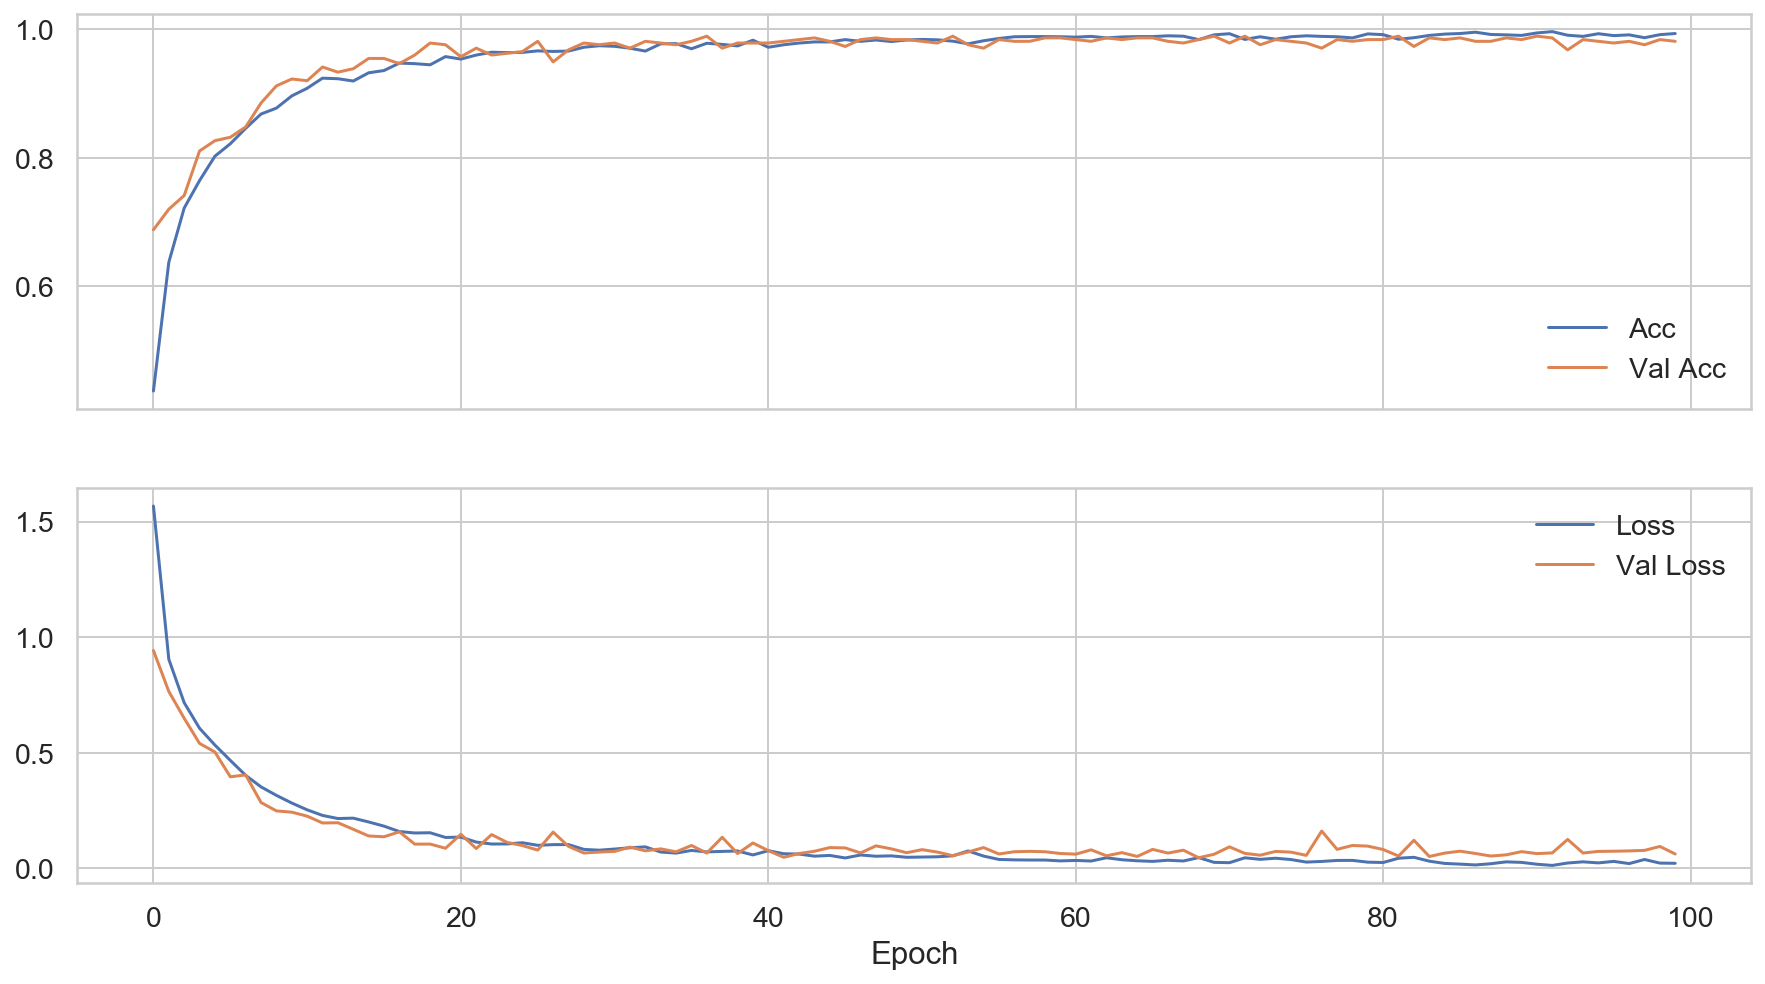

Saving trained source and target models
Source model path: ../Saved Model/mh_uci_source_model
Target model path: ../Saved Model/mh_mhealth_target_model
Performance of the source model mh_uci_source_model
10299/10299 [==============================] - 1s 61us/sample - loss: 0.3528 - acc: 0.8431
On Source Dataset Loss: 0.353, Accuracy 84.309
Performance of the target model mh_mhealth_target_model
4991/4991 [==============================] - 0s 65us/sample - loss: 0.0275 - acc: 0.9912
On Target Dataset Loss: 0.027, Accuracy 99.118


In [16]:
my_two_model.train_models("trans_dataset_uci_source_model", "trans_dataset_mhealth_target_model", cross_eval=False)

In [19]:
my_two_model.adversarial_init(epsilon, min_value, max_value, n_iterations, source_target_class, same_target_class=False, 
                             target_target_class=target_target_class)

In [20]:
my_two_model.adversarial_untargeted_attacks("trans_dataset_uci_source_untar_results", 
                                            "trans_dataset_mhealth_target_untar_results")

C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\attacks_tf.py:27: UserWarning: attacks_tf is deprecated and will be removed on 2019-07-18 or after. Code should import functions from their new locations directly.
  warnings.warn("attacks_tf is deprecated and will be removed on 2019-07-18"
[INFO 2020-11-10 21:00:48,425 cleverhans] Constructing new graph for attack FastGradientMethod



Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
dim is deprecated, use axis instead


C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_max_v1 at 0x000002DBF0A2B828> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_sum_v1 at 0x000002DBF0A288B8> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
[INFO 2020-11-10 21:00:48,812 cleverhans] Constructing new graph for a

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_max_v1 at 0x000002DBF0A2B828> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "


C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_sum_v1 at 0x000002DBF0A288B8> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_max_v1 at 0x000002DBF0A2B828> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
[INFO 2020-11-10 21:26:59,528 cleverhans] Constructing new graph for attack FastGradientMethod
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_max_v1 at 0x000002DBF0A2B828> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function 

C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_mean_v1 at 0x000002DBF0A28A68> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
[INFO 2020-11-10 21:57:28,202 cleverhans] Constructing new graph for attack SaliencyMapMethod
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_max_v1 at 0x000002DBF0A2B828> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent f

Saving the results of untargeted attacks.
Source model results at ../Results/texts/mh_uci_source_untar_results.csv
Source model results at ../Results/texts/mh_mhealth_target_untar_results.csv


In [22]:
my_two_model.adversarial_targeted_attacks("trans_dataset_uci_source_tar_results", 
                                          "trans_dataset_mhealth_target_tar_results")

[INFO 2020-11-10 23:05:27,202 cleverhans] Constructing new graph for attack FastGradientMethod
[INFO 2020-11-10 23:05:28,042 cleverhans] Constructing new graph for attack BasicIterativeMethod
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_sum_v1 at 0x000002DBF0A288B8> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
[INFO 2020-11-10 23:05:36,249 cleverhans] Constructing new graph for attack MomentumIterativeMethod
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_sum_v1 at 0x000002DBF0A288B8> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was original

[INFO 2020-11-11 00:14:43,206 cleverhans] Constructing new graph for attack BasicIterativeMethod
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_sum_v1 at 0x000002DBF0A288B8> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
[INFO 2020-11-11 00:14:51,262 cleverhans] Constructing new graph for attack MomentumIterativeMethod
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_sum_v1 at 0x000002DBF0A288B8> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versi

Saving the results of targeted attacks.
Source model results at ../Results/texts/trans_dataset_uci_source_tar_results.csv
Source model results at ../Results/texts/trans_dataset_mhealth_target_tar_results.csv


In [44]:
source_untar_results = pd.read_csv(data_result_path+"trans_dataset_uci_source_untar_results.csv")
source_tar_results = pd.read_csv(data_result_path+"trans_dataset_uci_source_tar_results.csv")

In [46]:
target_untar_results = pd.read_csv(data_result_path+"trans_dataset_mhealth_target_untar_results.csv")
target_tar_results = pd.read_csv(data_result_path+"trans_dataset_mhealth_target_tar_results.csv")

In [54]:
source_tar_results

,Unnamed: 0,Epsilon,Attack Method,Loss,Accuracy,Success Score
0,0,0.10,FGSM,0,0,8.628731
1,1,0.10,BIM,0,0,64.832090
2,2,0.10,MIM,0,0,58.582090
3,3,0.10,SMM,0,0,45.102612
4,4,0.10,CW,0,0,99.953358
5,5,0.25,FGSM,0,0,3.824627
6,6,0.25,BIM,0,0,92.397388
7,7,0.25,MIM,0,0,91.184701
8,8,0.25,SMM,0,0,49.020522
9,9,0.25,CW,0,0,99.953358


In [55]:
target_tar_results

,Unnamed: 0,Epsilon,Attack Method,Loss,Accuracy,Success Score
0,0,0.10,FGSM,0,0,0.0
1,1,0.10,BIM,0,0,0.0
2,2,0.10,MIM,0,0,0.0
3,3,0.10,SMM,0,0,0.0
4,4,0.10,CW,0,0,0.0
5,5,0.25,FGSM,0,0,0.0
6,6,0.25,BIM,0,0,0.0
7,7,0.25,MIM,0,0,0.0
8,8,0.25,SMM,0,0,0.0
9,9,0.25,CW,0,0,0.0


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

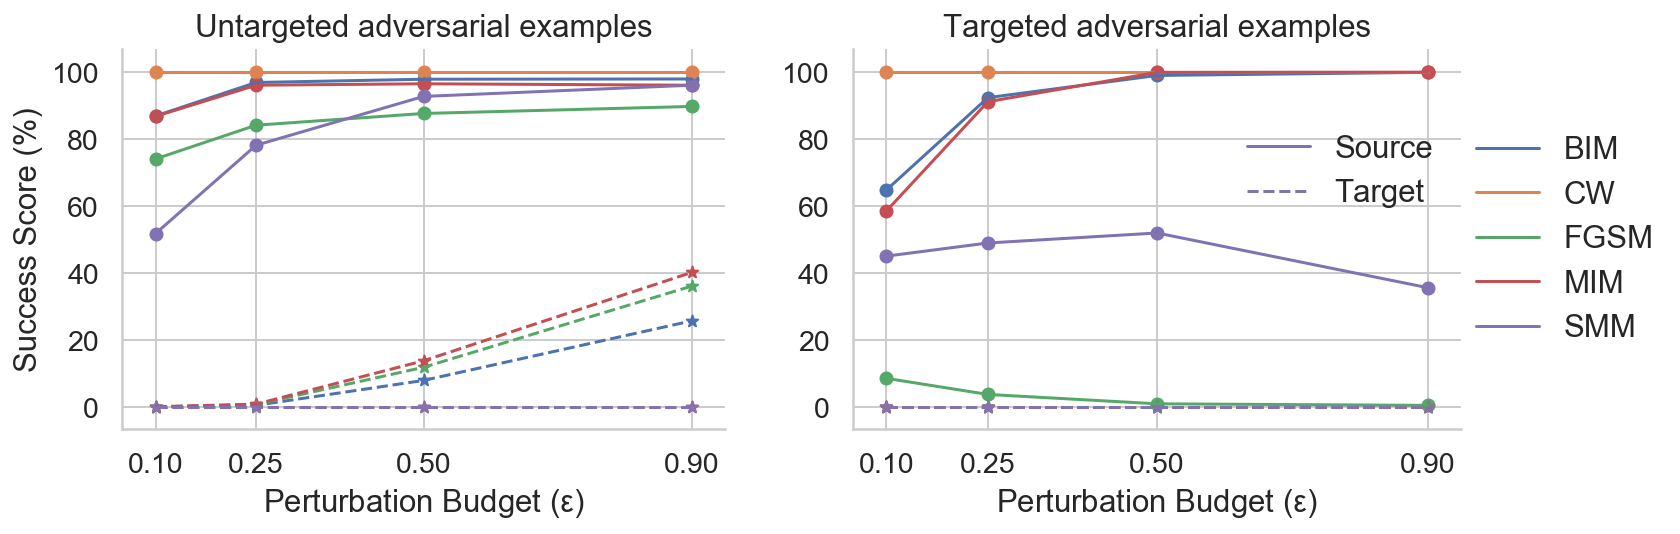

In [38]:
plot_untargeted_targeted_success_score(source_untar_results, source_tar_results, target_untar_results,
                                      target_tar_results, "uci_source_mhealth_target_cross_dataset")

# DL vs. UCI

In [24]:
my_two_model = TWA.TwoModel("../Processed data/adl_posture_dataset.pickle", 
                       "../Processed data/uci_body_acc_dataset.pickle", [], save_results=True)

Loading Source Dataset
X: (16434, 128, 3)
Y: (16434,)
N_classes: 6
Loading Target Dataset
X: (10299, 128, 3)
Y: (10299,)
N_classes: 6


In [25]:
my_two_model.prepare_for_training(batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, 
                                   n_epochs=N_EPOCHS)

Source
Training set (11092, 128, 3) 
Test set (4109, 128, 3)
Validation set (1233, 128, 3)
Target
Training set (6951, 128, 3) 
Test set (2575, 128, 3)
Validation set (773, 128, 3)


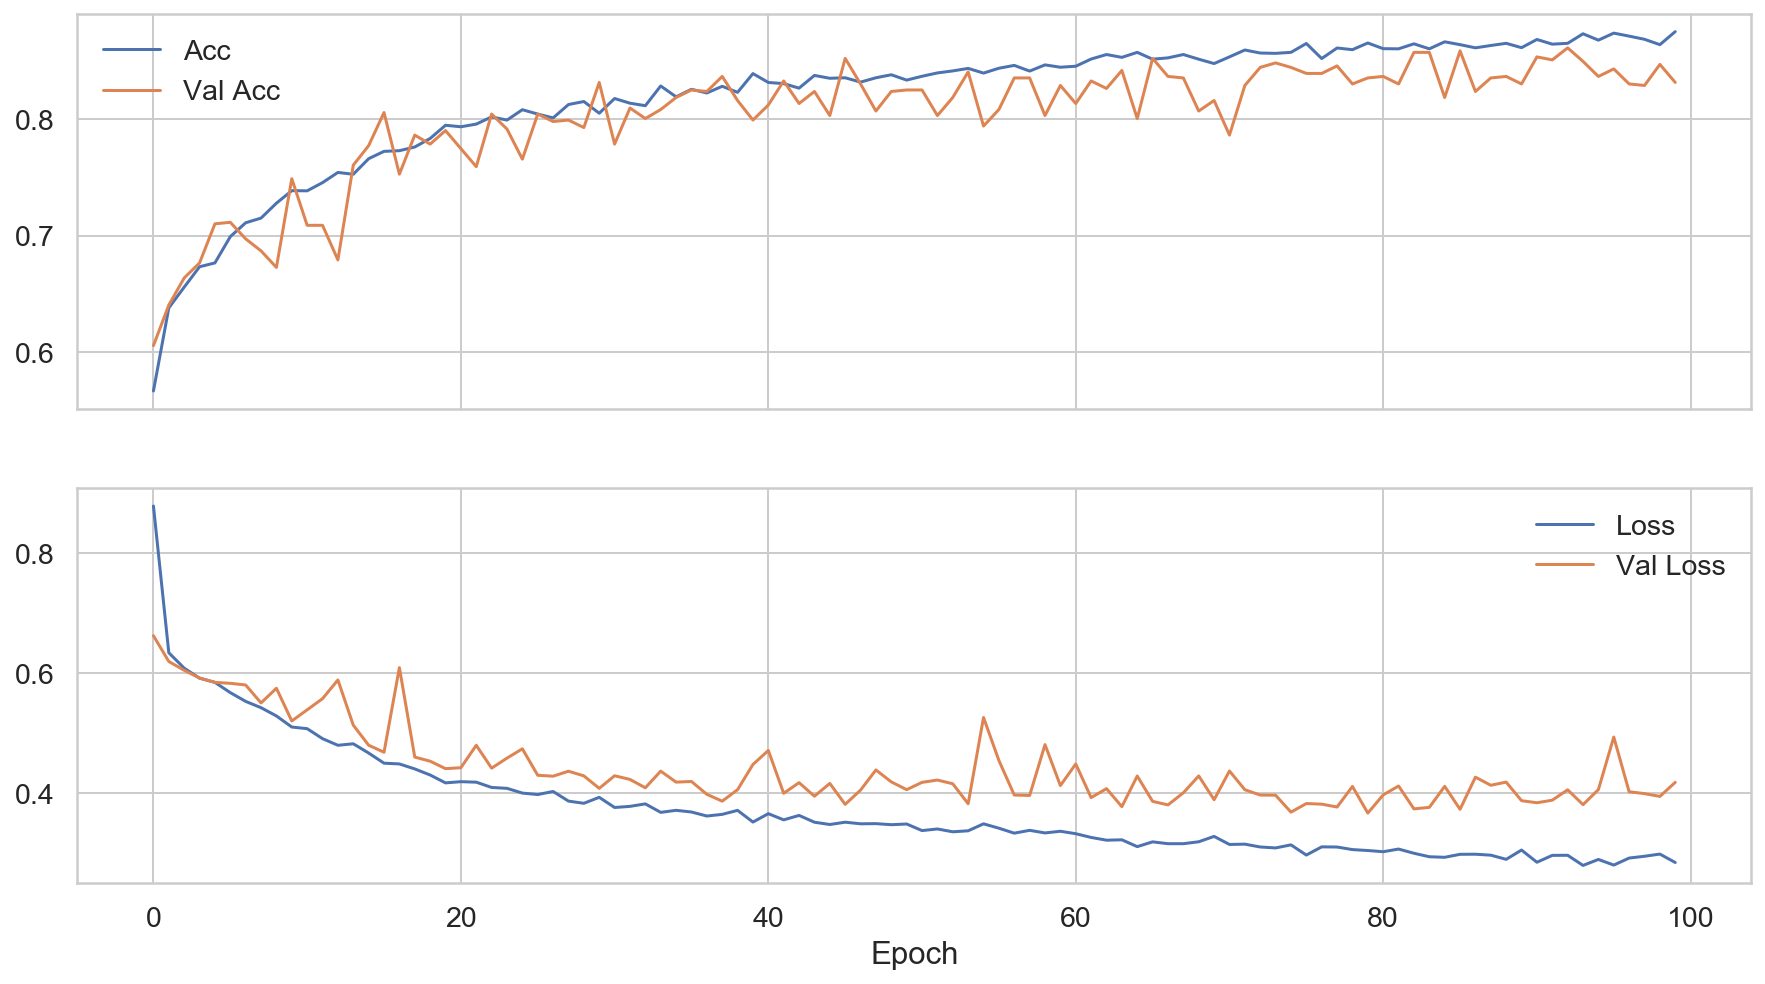

Saving trained source and target models
Source model path: ../Saved Model/trans_dataset_dl_source_model
Target model path: ../Saved Model/trans_dataset_uci_target_model
Performance of the source model trans_dataset_dl_source_model
16434/16434 [==============================] - 1s 82us/sample - loss: 0.2043 - acc: 0.95960s - loss: 0.2094 - acc: 0.9 - ETA: 0s - loss: 0.2121 - acc: 0.9 - ETA: 0s - loss: 0.2056 - acc:  - ETA: 0s - loss: 0.2072 - acc: 0.95
On Source Dataset Loss: 0.204, Accuracy 95.960
Performance of the target model trans_dataset_uci_target_model
10299/10299 [==============================] - 1s 79us/sample - loss: 0.3365 - acc: 0.8556
On Target Dataset Loss: 0.337, Accuracy 85.562


In [26]:
my_two_model.train_models("trans_dataset_dl_source_model", "trans_dataset_uci_target_model", cross_eval=False)

In [27]:
my_two_model.adversarial_init(epsilon, min_value, max_value, n_iterations, dl_target_class, same_target_class=False, 
                             target_target_class=uci_target_class)

In [28]:
my_two_model.adversarial_untargeted_attacks("trans_dataset_dl_source_untar_results", 
                                            "trans_dataset_uci_target_untar_results")

[INFO 2020-11-11 01:28:40,713 cleverhans] Constructing new graph for attack FastGradientMethod
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_max_v1 at 0x000002DBF0A2B828> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_sum_v1 at 0x000002DBF0A288B8> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent f

[INFO 2020-11-11 02:22:16,173 cleverhans] Constructing new graph for attack SaliencyMapMethod
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_max_v1 at 0x000002DBF0A2B828> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_sum_v1 at 0x000002DBF0A288B8> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent fu

[INFO 2020-11-11 04:08:39,592 cleverhans] Constructing new graph for attack BasicIterativeMethod
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_sum_v1 at 0x000002DBF0A288B8> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
[INFO 2020-11-11 04:09:03,226 cleverhans] Constructing new graph for attack MomentumIterativeMethod
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_max_v1 at 0x000002DBF0A2B828> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versi

Saving the results of untargeted attacks.
Source model results at ../Results/texts/trans_dataset_dl_source_untar_results.csv
Source model results at ../Results/texts/trans_dataset_uci_target_untar_results.csv


In [29]:
my_two_model.adversarial_targeted_attacks("trans_dataset_dl_source_tar_results", 
                                            "trans_dataset_uci_target_tar_results")

[INFO 2020-11-11 05:02:57,430 cleverhans] Constructing new graph for attack FastGradientMethod
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_sum_v1 at 0x000002DBF0A288B8> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
[INFO 2020-11-11 05:02:58,838 cleverhans] Constructing new graph for attack BasicIterativeMethod
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_sum_v1 at 0x000002DBF0A288B8> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions h

C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_sum_v1 at 0x000002DBF0A288B8> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
[INFO 2020-11-11 07:38:09,268 cleverhans] Constructing new graph for attack BasicIterativeMethod
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_sum_v1 at 0x000002DBF0A288B8> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent

Saving the results of targeted attacks.
Source model results at ../Results/texts/trans_dataset_dl_source_tar_results.csv
Source model results at ../Results/texts/trans_dataset_uci_target_tar_results.csv


In [56]:
source_untar_results = pd.read_csv(data_result_path+"trans_dataset_dl_source_untar_results.csv")
source_tar_results = pd.read_csv(data_result_path+"trans_dataset_dl_source_tar_results.csv")

target_untar_results = pd.read_csv(data_result_path+"trans_dataset_uci_target_untar_results.csv")
target_tar_results = pd.read_csv(data_result_path+"trans_dataset_uci_target_tar_results.csv")

In [65]:
source_tar_results

,Unnamed: 0,Epsilon,Attack Method,Loss,Accuracy,Success Score
0,0,0.10,FGSM,0,0,0.438084
1,1,0.10,BIM,0,0,52.248832
2,2,0.10,MIM,0,0,56.220794
3,3,0.10,SMM,0,0,4.059579
4,4,0.10,CW,0,0,99.853972
5,5,0.25,FGSM,0,0,0.175234
6,6,0.25,BIM,0,0,67.640187
7,7,0.25,MIM,0,0,71.524533
8,8,0.25,SMM,0,0,3.738318
9,9,0.25,CW,0,0,99.853972


In [66]:
target_tar_results

,Unnamed: 0,Epsilon,Attack Method,Loss,Accuracy,Success Score
0,0,0.10,FGSM,0,0,11.510791
1,1,0.10,BIM,0,0,11.704483
2,2,0.10,MIM,0,0,7.415606
3,3,0.10,SMM,0,0,2.268954
4,4,0.10,CW,0,0,1.438849
5,5,0.25,FGSM,0,0,4.039845
6,6,0.25,BIM,0,0,9.324848
7,7,0.25,MIM,0,0,3.901494
8,8,0.25,SMM,0,0,1.079137
9,9,0.25,CW,0,0,1.466519


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

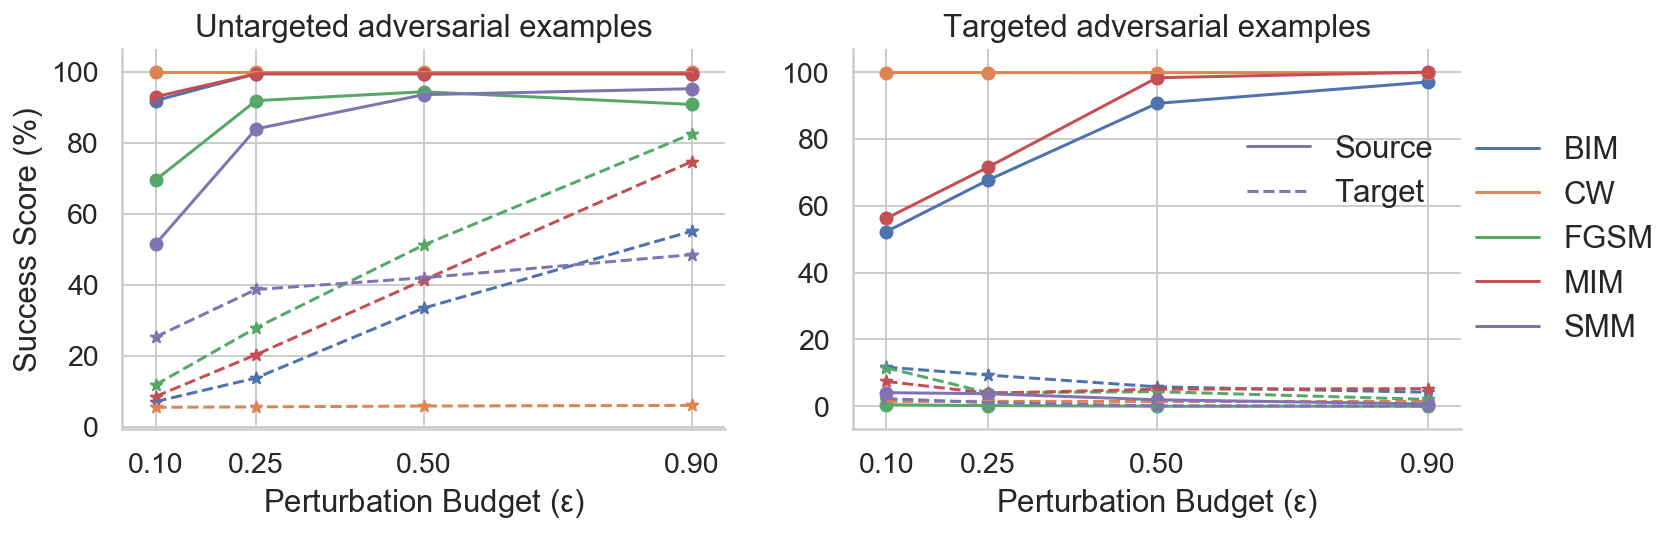

In [40]:
plot_untargeted_targeted_success_score(source_untar_results, source_tar_results, target_untar_results,
                                      target_tar_results, "dl_source_uci_target_cross_dataset")

# MHEALTH Vs. DL

In [30]:
my_two_model = TWA.TwoModel("../Processed data/mHealth_wrist_dataset.pickle", 
                       "../Processed data/adl_posture_dataset.pickle", [], save_results=True)

Loading Source Dataset
X: (4991, 128, 3)
Y: (4991,)
N_classes: 11
Loading Target Dataset
X: (16434, 128, 3)
Y: (16434,)
N_classes: 6


In [31]:
my_two_model.prepare_for_training(batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, 
                                   n_epochs=N_EPOCHS)

Source
Training set (3368, 128, 3) 
Test set (1248, 128, 3)
Validation set (375, 128, 3)
Target
Training set (11092, 128, 3) 
Test set (4109, 128, 3)
Validation set (1233, 128, 3)


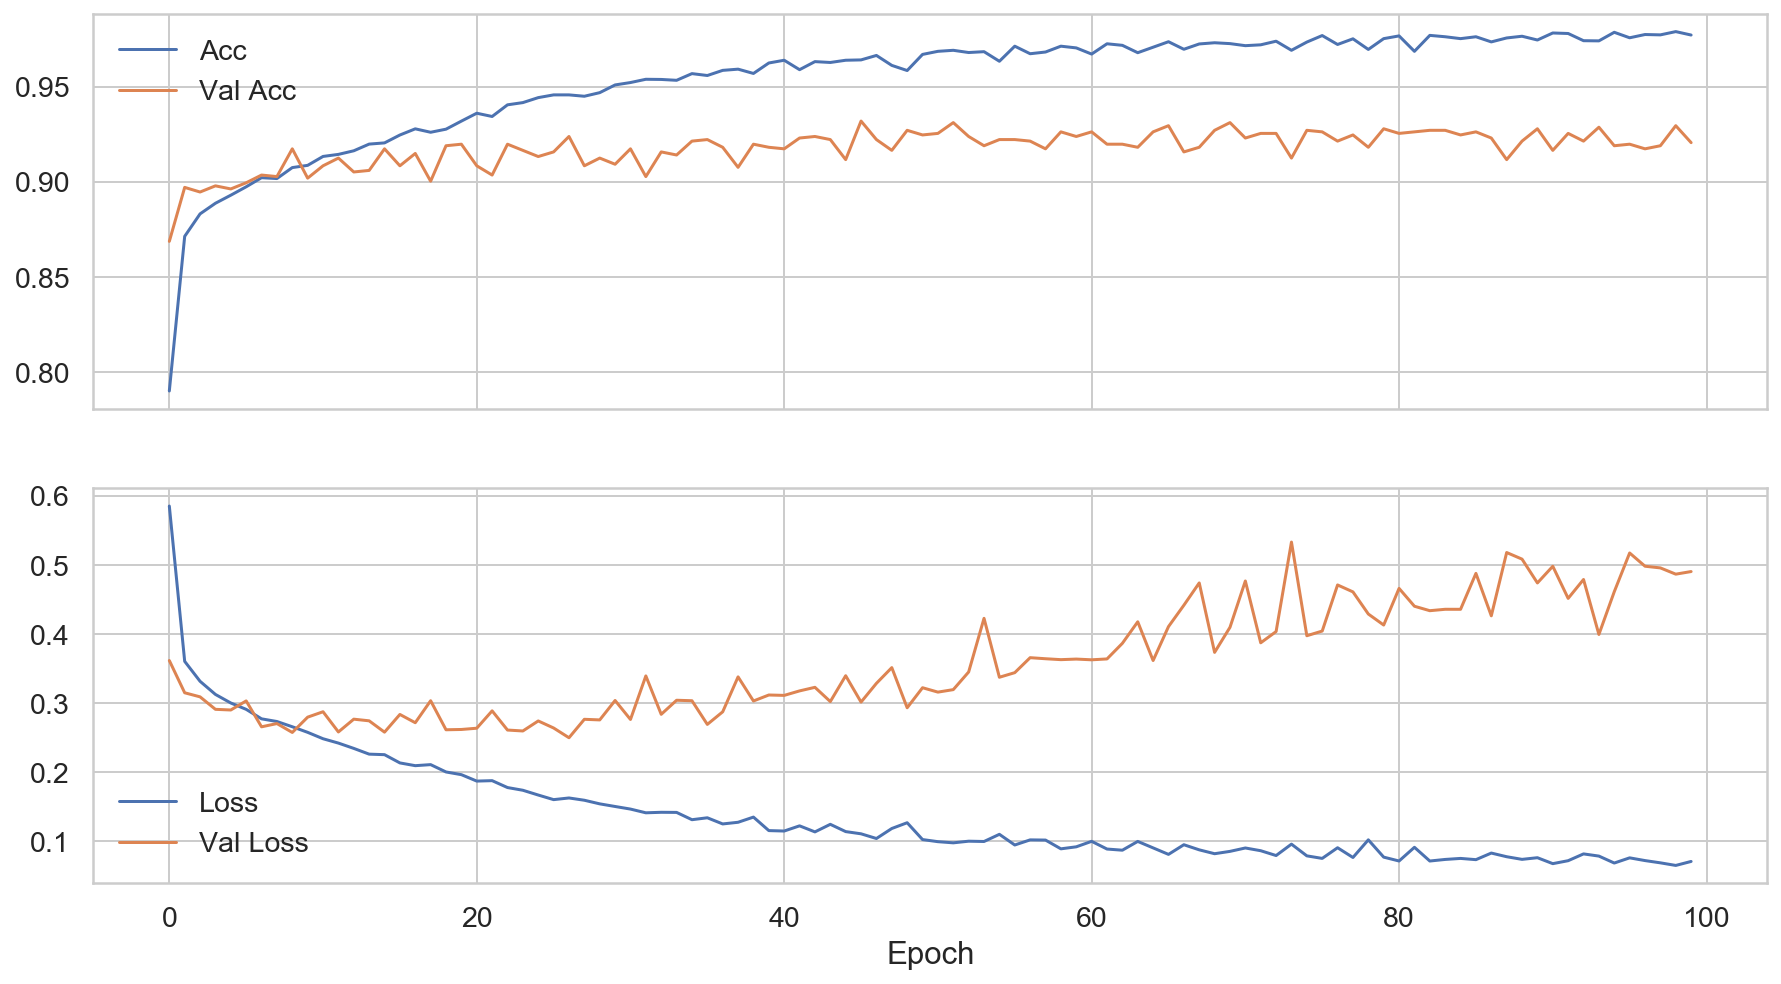

Saving trained source and target models
Source model path: ../Saved Model/trans_dataset_mhealth_source_model
Target model path: ../Saved Model/trans_dataset_dl_target_model
Performance of the source model trans_dataset_mhealth_source_model
4991/4991 [==============================] - 3s 608us/sample - loss: 0.0245 - acc: 0.9942
On Source Dataset Loss: 0.025, Accuracy 99.419
Performance of the target model trans_dataset_dl_target_model
16434/16434 [==============================] - 7s 447us/sample - loss: 0.2020 - acc: 0.9570
On Target Dataset Loss: 0.202, Accuracy 95.704


In [32]:
my_two_model.train_models("trans_dataset_mhealth_source_model", "trans_dataset_dl_target_model", cross_eval=False)

In [33]:
my_two_model.adversarial_init(epsilon, min_value, max_value, n_iterations, mh_target_class, same_target_class=False, 
                             target_target_class=dl_target_class)

In [34]:
my_two_model.adversarial_untargeted_attacks("trans_dataset_mhealth_source_untar_results", 
                                            "trans_dataset_dl_target_untar_results")

[INFO 2020-11-11 10:56:26,618 cleverhans] Constructing new graph for attack FastGradientMethod
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_max_v1 at 0x000002DBF0A2B828> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_sum_v1 at 0x000002DBF0A288B8> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent f

[INFO 2020-11-11 11:22:24,359 cleverhans] Constructing new graph for attack SaliencyMapMethod
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_max_v1 at 0x000002DBF0A2B828> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_sum_v1 at 0x000002DBF0A288B8> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent fu

[INFO 2020-11-11 12:08:41,557 cleverhans] Constructing new graph for attack BasicIterativeMethod
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_sum_v1 at 0x000002DBF0A288B8> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
[INFO 2020-11-11 12:08:54,096 cleverhans] Constructing new graph for attack MomentumIterativeMethod
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_max_v1 at 0x000002DBF0A2B828> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versi

Saving the results of untargeted attacks.
Source model results at ../Results/texts/trans_dataset_mhealth_source_untar_results.csv
Source model results at ../Results/texts/trans_dataset_dl_target_untar_results.csv


In [35]:
my_two_model.adversarial_targeted_attacks("trans_dataset_mhealth_source_tar_results", 
                                            "trans_dataset_dl_target_tar_results")

[INFO 2020-11-11 12:32:45,481 cleverhans] Constructing new graph for attack FastGradientMethod
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_sum_v1 at 0x000002DBF0A288B8> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
[INFO 2020-11-11 12:32:47,164 cleverhans] Constructing new graph for attack BasicIterativeMethod
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_sum_v1 at 0x000002DBF0A288B8> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions h

C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_sum_v1 at 0x000002DBF0A288B8> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
[INFO 2020-11-11 13:36:08,386 cleverhans] Constructing new graph for attack BasicIterativeMethod
C:\Users\rames\Anaconda3\envs\venvTF1.15\lib\site-packages\cleverhans\compat.py:22: UserWarning: <function reduce_sum_v1 at 0x000002DBF0A288B8> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent

Saving the results of targeted attacks.
Source model results at ../Results/texts/trans_dataset_mhealth_source_tar_results.csv
Source model results at ../Results/texts/trans_dataset_dl_target_tar_results.csv


In [67]:
source_untar_results = pd.read_csv(data_result_path+"trans_dataset_mhealth_source_untar_results.csv")
source_tar_results = pd.read_csv(data_result_path+"trans_dataset_mhealth_source_tar_results.csv")

target_untar_results = pd.read_csv(data_result_path+"trans_dataset_dl_target_untar_results.csv")
target_tar_results = pd.read_csv(data_result_path+"trans_dataset_dl_target_tar_results.csv")

In [72]:
source_untar_results

,Unnamed: 0,Epsilon,Attack Method,Loss,Accuracy,Success Score,Modified Success Score
0,0,0.10,FGSM,0.0,0.0,62.820513,64.583333
1,1,0.10,BIM,0.0,0.0,79.086538,80.769231
2,2,0.10,MIM,0.0,0.0,80.929487,82.692308
3,3,0.10,SMM,0.0,0.0,40.464744,40.464744
4,4,0.10,CW,0.0,0.0,98.157051,100.000000
5,5,0.25,FGSM,0.0,0.0,82.051282,83.333333
6,6,0.25,BIM,0.0,0.0,98.076923,99.839744
7,7,0.25,MIM,0.0,0.0,97.676282,99.439103
8,8,0.25,SMM,0.0,0.0,66.826923,67.067308
9,9,0.25,CW,0.0,0.0,98.157051,100.000000


In [73]:
target_untar_results

,Unnamed: 0,Epsilon,Attack Method,Loss,Accuracy,Success Score,Modified Success Score
0,0,0.10,FGSM,0.0,0.0,91.105769,24.358974
1,1,0.10,BIM,0.0,0.0,87.740385,21.474359
2,2,0.10,MIM,0.0,0.0,88.060897,25.560897
3,3,0.10,SMM,0.0,0.0,89.182692,20.993590
4,4,0.10,CW,0.0,0.0,84.134615,12.580128
5,5,0.25,FGSM,0.0,0.0,90.945513,30.849359
6,6,0.25,BIM,0.0,0.0,91.826923,33.894231
7,7,0.25,MIM,0.0,0.0,90.304487,32.371795
8,8,0.25,SMM,0.0,0.0,90.064103,35.336538
9,9,0.25,CW,0.0,0.0,84.214744,12.419872


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

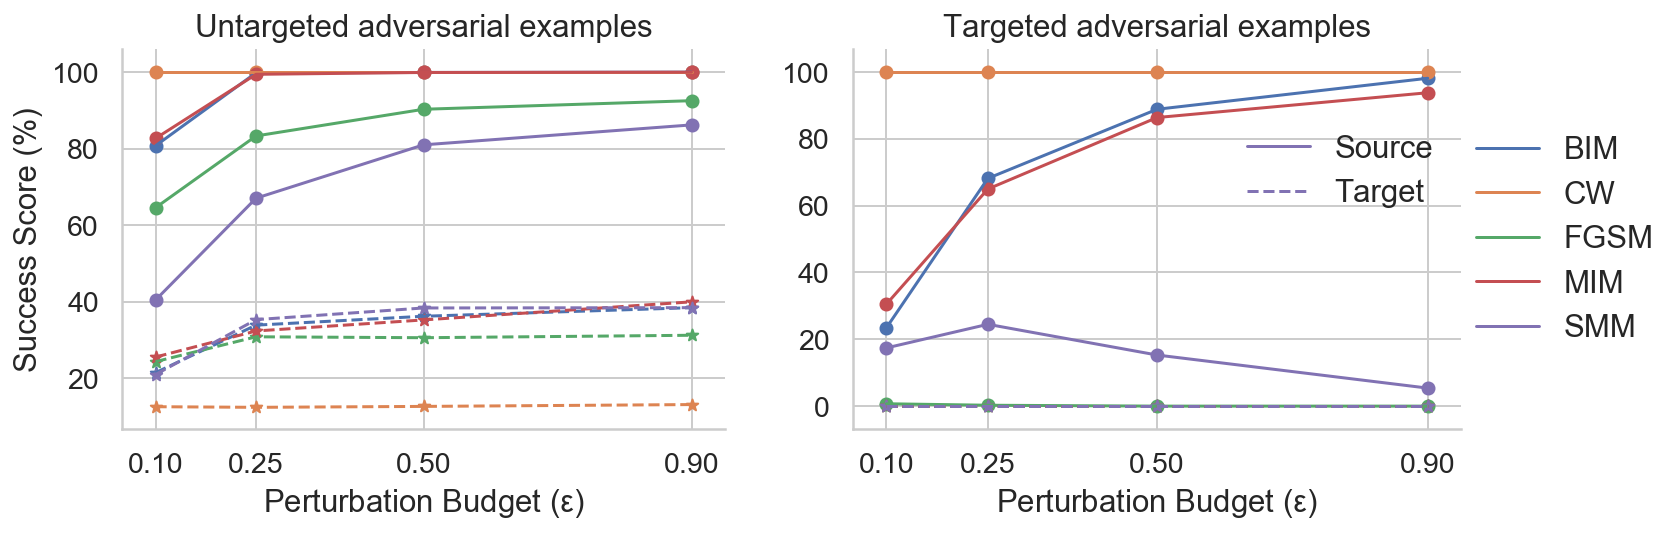

In [43]:
plot_untargeted_targeted_success_score(source_untar_results, source_tar_results, target_untar_results,
                                      target_tar_results, "mhealth_source_dl_target_cross_dataset")